In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import matplotlib.pyplot as plt
import pattern.vis as vis
import sklearn.mixture as mix
import matplotsoccer as mps
import atomic.vaep as vaep
import pattern.action as pat

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions-one-action.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore,\
    pd.HDFStore(predictions_h5) as predstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        p = predstore[f"game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        assert len(a) == len(p)
        a = pd.concat([a,p],axis=1)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]
actions = pd.concat([actions,vaep.value(actions,actions.scores,actions.concedes)],axis=1)

380it [00:13, 29.02it/s]


In [158]:
# Make a nice action subset
import pattern.action as pat

#a = actions[300000:400000].fillna(0)
a = actions.fillna(0)
a = pat.simplify(a)
#a["type_name"] = a.type_name.mask(~a.is_home,a.type_name + "_opp")
a["x"] = a.x.mask(a.type_name=="goal",105)
a["y"] = a.y.mask(a.type_name=="goal",34)
#a["dx"] = a.dx.mask(a.type_name=="shot",105-a.x)
#a["dy"] = a.dy.mask(a.type_name=="shot",32.5-a.y)
a = pd.concat([a,fs.polar(a),fs.movement_polar(a),fs.direction(a)],axis=1)
a

game_id  period_id  action_id  time_seconds     timestamp  team_id  \
0        14562.0        1.0          0           1.0  00:00:01.344     58.0   
1        14562.0        1.0          1           1.5  00:00:02.117     58.0   
2        14562.0        1.0          2           2.0  00:00:02.117     58.0   
3        14562.0        1.0          3           2.0  00:00:02.969     58.0   
4        14562.0        1.0          4           3.0  00:00:04.338     58.0   
...          ...        ...        ...           ...           ...      ...   
1188665  14650.0        2.0       3626        2786.0  00:46:26.541     55.0   
1188666  14650.0        2.0       3627        2788.0  00:46:28.357     55.0   
1188667  14650.0        2.0       3628        2790.0  00:46:32.235     37.0   
1188668  14650.0        2.0       3629        2792.0  00:46:32.235     37.0   
1188669  14650.0        2.0       3630        2798.0  00:46:38.464     55.0   

         player_id          x          y         dx  ...     type_name  \
0           9923.0  52.058824  34.430380 -10.588235  ...          pass   
1           9917.0  41.470588  34.430380  -0.000000  ...      receival   
2           9917.0  41.470588  34.430380  -0.000000  ...       dribble   
3           9917.0  41.470588  34.430380 -15.882353  ...          pass   
4           9924.0  25.588235  19.797468  -0.000000  ...      receival   
...            ...        ...        ...        ...  ...           ...   
1188665     9604.0  51.176471  61.113924   0.000000  ...       dribble   
1188666     9604.0  51.176471  61.113924  50.294118  ...          pass   
1188667     5537.0   3.529412  16.354430  -0.000000  ...  interception   
1188668     5537.0   3.529412  16.354430   8.823529  ...       dribble   
1188669    10284.0  92.647059  65.417722   0.000000  ...          foul   

         offensive_value  defensive_value  vaep_value  dist_to_goal_a0  \
0               0.000000        -0.000000    0.000000        52.942926   
1               0.000398         0.000038    0.000436        63.530870   
2              -0.000033        -0.000016   -0.000049        63.530870   
3              -0.000265        -0.000013   -0.000278        63.530870   
4              -0.000026        -0.000026   -0.000052        80.671806   
...                  ...              ...         ...              ...   
1188665        -0.000093        -0.000072   -0.000166        60.267215   
1188666         0.002012         0.000042    0.002054        60.267215   
1188667         0.000108         0.000071    0.000179       102.993429   
1188668        -0.000041         0.001796    0.001755       102.993429   
1188669        -0.000205        -0.000357   -0.000562        33.758975   

         angle_to_goal_a0   mov_d_a0  mov_angle_a0     dx_a0     dy_a0  
0                0.008129  10.588235      0.000000 -1.000000 -0.000000  
1                0.006774   0.000000      0.000000 -0.000000 -0.000000  
2                0.006774   0.000000      0.000000 -0.000000 -0.000000  
3                0.006774  21.595630     -2.397116 -0.735443 -0.677587  
4                0.176976   0.000000      0.000000 -0.000000 -0.000000  
...                   ...        ...           ...       ...       ...  
1188665          0.466648   0.000000      0.000000  0.000000  0.000000  
1188666          0.466648  51.177612     -0.186082  0.982737 -0.185010  
1188667          0.172177   0.000000      0.000000 -0.000000 -0.000000  
1188668          0.172177  16.356248     -1.001002  0.539459 -0.842012  
1188669          1.196180   0.000000      0.000000  0.000000  0.000000  

[1188670 rows x 26 columns]

0.0    25631
Name: mov_angle_a0, dtype: int64

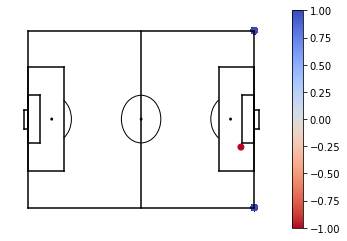

197


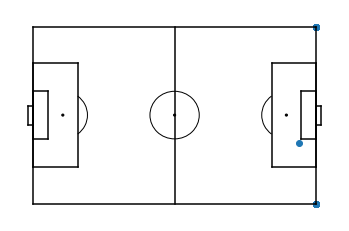

3685


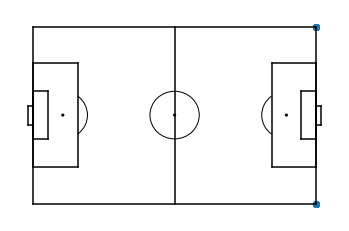

In [178]:
from sklearn.ensemble import IsolationForest as IF
from sklearn.neighbors import LocalOutlierFactor as LOF

s = a[a.type_name == "corner"]
mps.field(show=False)

#model = IF(contamination=0.001).fit(s[["x","y"]])
# c = model.decision_function(s[["x","y"]])
#c = model.predict(s[["x","y"]])

c = LOF().fit_predict(s[["x","y","mov_angle_a0"]])
#c = lof.decision_function(s[["x","y"]])

plt.scatter(s.x,s.y,c=c,cmap="coolwarm_r")
plt.colorbar()
plt.show()
for i in [-1,1]:
    print(sum(c==i))
    mps.field(show=False)
    plt.scatter(s.x[c==i],s.y[c==i])
    plt.show()

In [179]:
import sklearn
import sklearn.mixture as mix
from sklearn.mixture._gaussian_mixture import (
    _estimate_gaussian_parameters,
    _compute_precision_cholesky,
    )
import numpy as np

import sklearn.cluster as cluster

class WeightedGMM(mix.GaussianMixture):
    
    def fit(self,X,weights=None,*k,**kw):
        if weights is None:
            weights = np.zeros(len(X)) + 1
        pos_weight_idx = weights > 1e-10
        self.Xweights = weights[pos_weight_idx]
        return super().fit(X[pos_weight_idx],*k,**kw)
        
    def _m_step(self, X, log_resp):
            """M step.
            Parameters
            ----------
            X : array-like, shape (n_samples, n_features)
            log_resp : array-like, shape (n_samples, n_components)
                Logarithm of the posterior probabilities (or responsibilities) of
                the point of each sample in X.
            """
            resp = (self.Xweights*np.exp(log_resp).T).T
            self.weights_, self.means_, self.covariances_ = (
                _estimate_gaussian_parameters(X,resp, self.reg_covar,
                                              self.covariance_type))
            self.weights_ /= np.sum(self.Xweights)
            self.precisions_cholesky_ = _compute_precision_cholesky(
                self.covariances_, self.covariance_type)
            
    def _initialize_parameters(self, X, random_state):
            """Initialize the model parameters.
            Parameters
            ----------
            X : array-like, shape  (n_samples, n_features)
            random_state : RandomState
                A random number generator instance.
            """
            n_samples, _ = X.shape

            if self.init_params == 'kmeans':
                resp = np.zeros((n_samples, self.n_components))
                clus = cluster.KMeans(n_clusters=self.n_components, n_init=1,
                                       random_state=random_state)
                label = clus.fit(X,sample_weight=self.Xweights).labels_
                resp[np.arange(n_samples), label] = 1
            elif self.init_params == 'random':
                resp = random_state.rand(n_samples, self.n_components)
                resp /= resp.sum(axis=1)[:, np.newaxis]
            else:
                raise ValueError("Unimplemented initialization method '%s'"
                                 % self.init_params)

            self._initialize(X, resp)
            
    def score_samples(self,X,weights=None):
        if weights is None:
            weights = np.zeros(len(X)) + 1
        pos_weights_idx = weights > 1e-10
        
        scores = np.zeros(len(X))
        pos_weights = weights[pos_weights_idx]
        pos_scores = super().score_samples(X[pos_weights_idx])
        scores[pos_weights_idx] = (pos_weights*pos_scores.T).T
        return scores
    
    def predict_proba(self,X,weights=None):
        if weights is None:
            weights = np.zeros(len(X)) + 1
        pos_weights_idx = weights > 1e-10
        
        p = np.zeros((len(X),self.n_components))
        pos_weights = weights[pos_weights_idx]
        pos_probs = super().predict_proba(X[pos_weights_idx])
        p[pos_weights_idx,:] = (pos_weights*pos_probs.T).T
        return p

def candidates(df,columns,weightsdf,n=5,verbose=True):
    candidates = []
    for name in weightsdf.columns:
        weights = weightsdf[name].values
        n_components = range(1,min(n+1,int(sum(weights))))
        if verbose:
            n_components = tqdm.tqdm(n_components,desc=name)
        for i in n_components:
            try:
                model = WeightedGMM(n_components=i).fit(df[columns].values,weights)
                model.name = name
                #model.loglikelihood = model.score_samples(X,weights).sum()
                model.df=df
                model.columns = columns
                model.weights = weights
                model.likelihood = model.score_samples(
                    df[columns],weights
                ).sum()
                candidates.append(model)
            except sklearn.exceptions.ConvergenceWarning:
                break
    return candidates

# def scores(models,verbose=True):
#     if verbose:
#         models = tqdm.tqdm(models)
#     return list((model.name,
#                  model.n_components,
#                  model.score_samples(model.df[model.columns],
#                                      model.weights).sum())
#                 for model in models)

def probabilities(models):
    weights = []
    for model in models:
        probs = model.predict_proba(model.df[model.columns].values,model.weights)
        columns = list(f"{model.name}_{i}" for i in range(model.n_components))
        weights.append(pd.DataFrame(probs,columns=columns))
    return pd.concat(weights,axis=1)

In [69]:
bool(0)

False

In [180]:
from sklearn.neighbors import LocalOutlierFactor as LOF

cols = ["x","y",
        #"dx","dy"
        #"dist_to_goal_a0",
        #"angle_to_goal_a0",
        #"mov_d_a0",
        #"mov_angle_a0"
        #"dx_a0",
        #"dy_a0"
       ]

w = pd.DataFrame()
#for t in ["dribble","pass","shot","cross"]:
for t in set(a.type_name):
    t_idx = (a.type_name == t)
    if sum(t_idx) > 20:
        c = LOF().fit_predict(a[t_idx][["x","y","mov_angle_a0"]])
        t_idx[t_idx] = c==1
        print(f"removed {sum(c==-1)} {t} examples, {sum(t_idx)} examples remaining")
        w[t] = t_idx.apply(float)

can_i = candidates(a,cols,w,n=30)

removed 24 tackle examples, 13010 examples remaining
removed 1687 out examples, 13785 examples remaining
removed 5 foul examples, 8919 examples remaining
removed 9141 receival examples, 298710 examples remaining
removed 29644 dribble examples, 303550 examples remaining
removed 1 owngoal examples, 31 examples remaining
removed 4 yellow_card examples, 985 examples remaining
removed 368 keeper_catch examples, 3459 examples remaining
removed 197 corner examples, 3685 examples remaining
removed 32 freekick examples, 8807 examples remaining
removed 0 red_card examples, 27 examples remaining
removed 131 shot examples, 9068 examples remaining
removed 548 throw_in examples, 15832 examples remaining
removed 13 take_on examples, 11662 examples remaining
removed 9 cross examples, 8275 examples remaining
removed 1924 pass examples, 335154 examples remaining
removed 99 goalkick examples, 5735 examples remaining
removed 1727 interception examples, 72264 examples remaining
removed 4 shot_penalty examp

corner:   0%|          | 0/30 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
corner:  17%|█▋        | 5/30 [00:00<00:00, 42.10it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
/home/to

goalkick:  97%|█████████▋| 29/30 [00:07<00:00,  2.77it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (30). Possibly due to duplicate points in X.


shot_penalty:  17%|█▋        | 5/30 [00:00<00:00, 48.07it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
shot_penalty:  33%|███▎      | 10/30 [00:00<00:00, 46.22it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (11). Possibly due to duplicat

bad_touch: 100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


In [181]:
models_i = pat.ilp_select_models_bic(can_i,verbose=True)
list((m.name,m.n_components) for m in models_i)

Iter	Lower Bound	Upper Bound	Gap

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.903e+07  -8.914e+07  +1e+08  7e-03  3e-10  1e+00  8e+04    ---    ---    1  1  - |  -  - 
 1  +1.880e+07  +1.490e+07  +4e+06  6e-03  1e-11  5e+02  3e+03  0.9691  7e-03   0  1  1 |  0  0
 2  +1.877e+07  +1.581e+07  +3e+06  4e-03  9e-12  1e+03  2e+03  0.5902  6e-01   0  1  1 |  0  0
 3  +1.886e+07  +1.825e+07  +7e+05  2e-03  2e-12  3e+02  5e+02  0.8066  2e-02   0  1  1 |  0  0
 4  +1.885e+07  +1.833e+07  +6e+05  2e-03  2e-12  3e+02  4e+02  0.3692  6e-01   0  2  1 |  0  0
 5  +1.885e+07  +1.878e+07  +8e+04  5e-04  2e-13  5e+01  6e+01  0.9890  1e-01   0  2  2 |  0  0
 6  +1.884e+07  +1.882e+07  +3e+04  2e-04  7e-14  2e+01  2e+01  0.8400  2e-01   0  2  2 |  0  0
 7  +1.884e+07  +1.882e+07  +2e+04  1e-04  5e-14  1e+01  1e+01  0.5403  5e-01   0  2  1 |  0  0
 8  +1.883e+0

[('tackle', 11),
 ('out', 28),
 ('foul', 9),
 ('receival', 30),
 ('dribble', 24),
 ('owngoal', 1),
 ('yellow_card', 3),
 ('keeper_catch', 9),
 ('corner', 2),
 ('freekick', 10),
 ('red_card', 1),
 ('shot', 7),
 ('throw_in', 12),
 ('take_on', 16),
 ('cross', 16),
 ('pass', 21),
 ('goalkick', 1),
 ('interception', 26),
 ('shot_penalty', 5),
 ('offside', 4),
 ('clearance', 19),
 ('goal', 1),
 ('bad_touch', 9)]

In [182]:
w_i = probabilities(models_i)

tackle 11


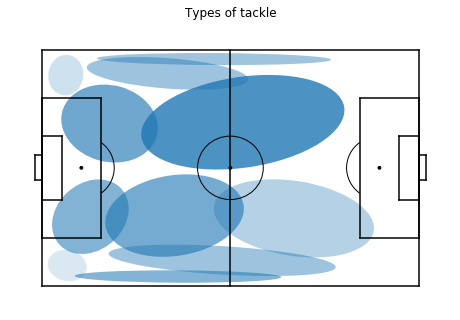

out 28


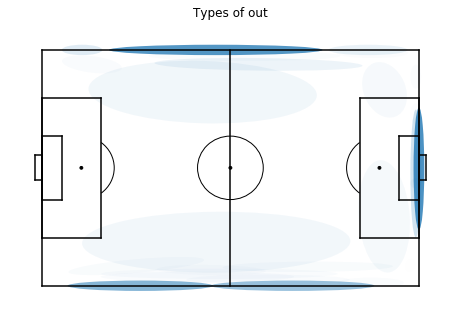

foul 9


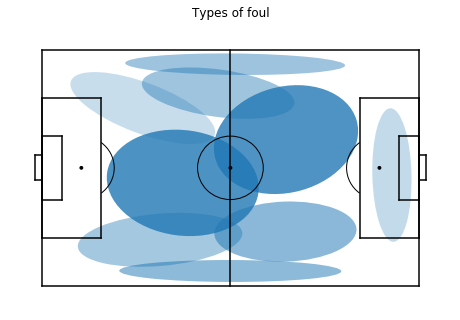

receival 30


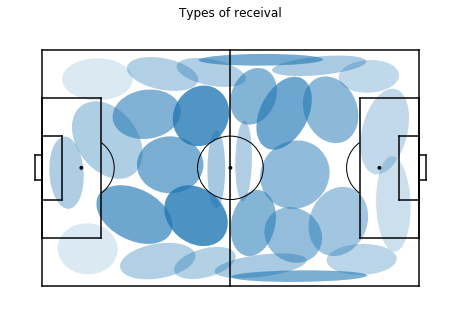

dribble 24


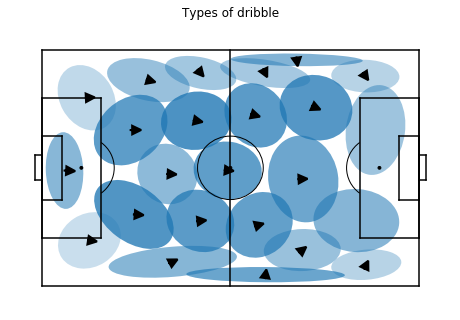

owngoal 1


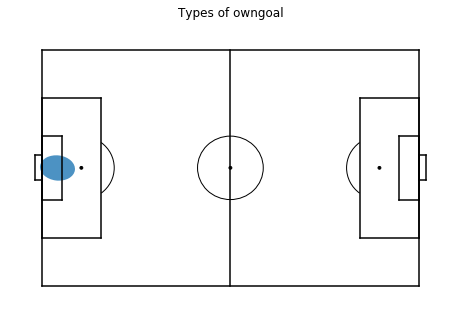

yellow_card 3


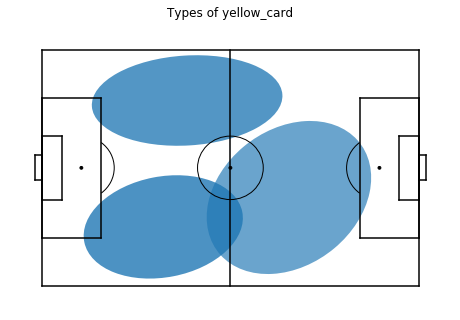

keeper_catch 9


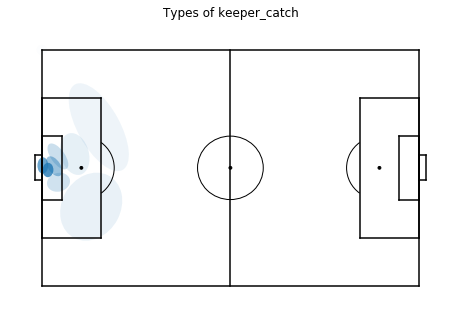

corner 2


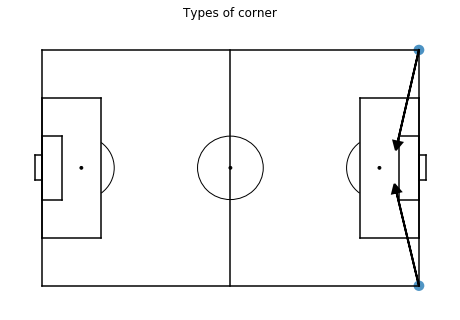

freekick 10


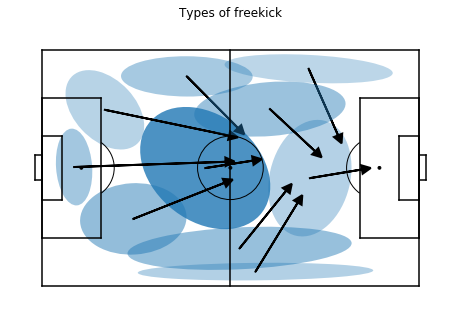

red_card 1


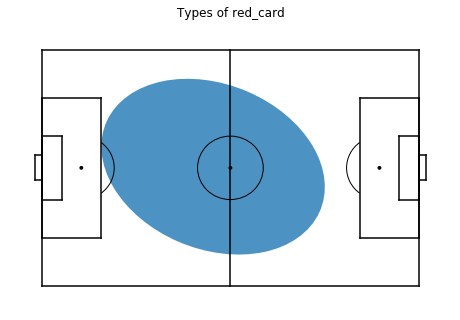

shot 7


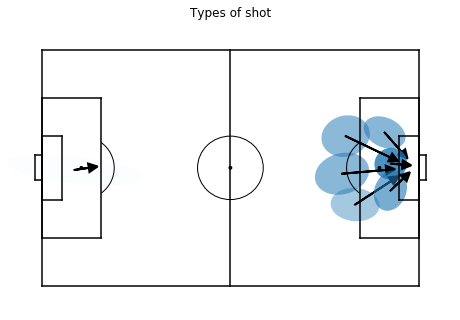

throw_in 12


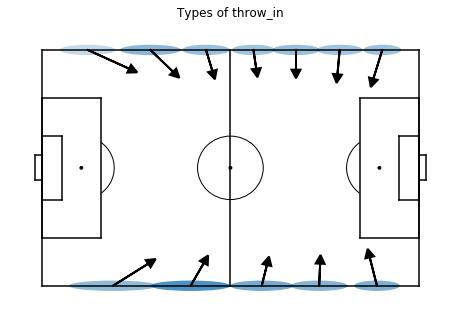

take_on 16


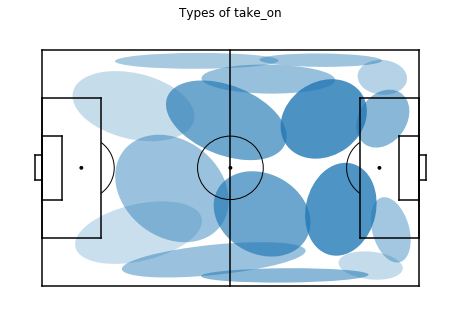

cross 16


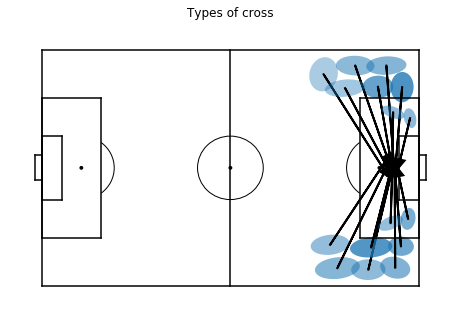

pass 21


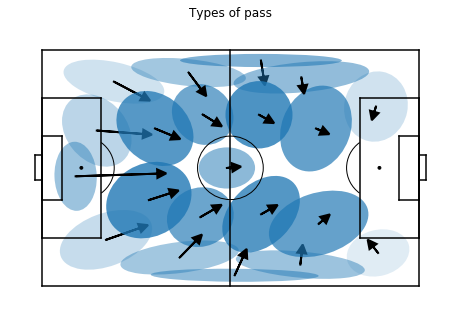

goalkick 1


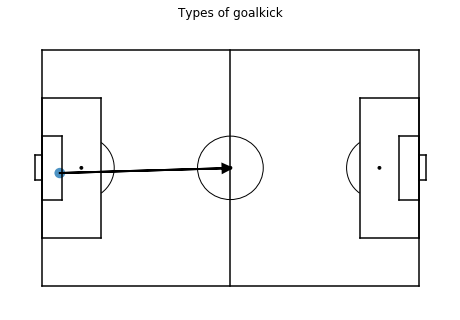

interception 26


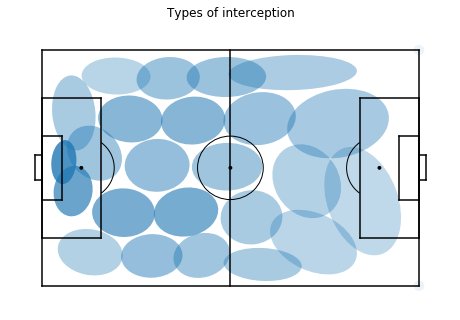

shot_penalty 5


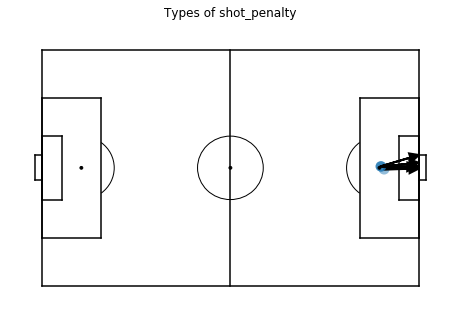

offside 4


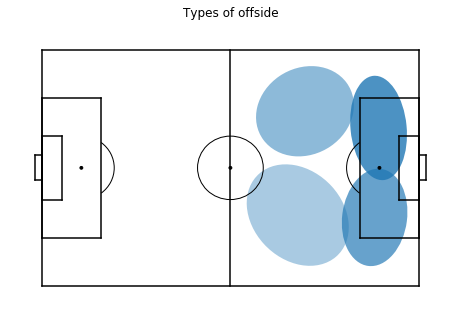

clearance 19


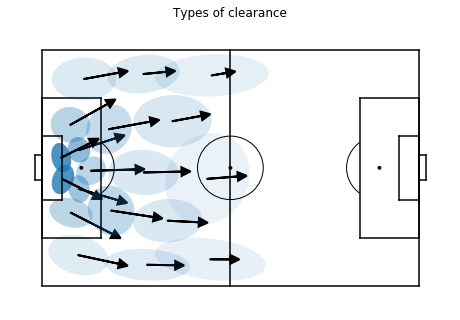

goal 1


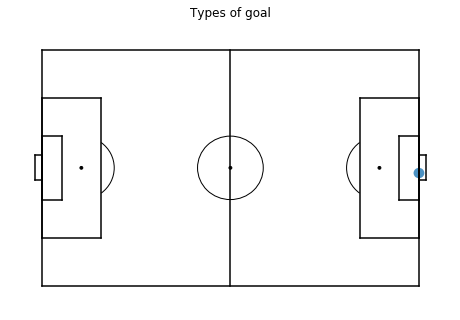

bad_touch 9


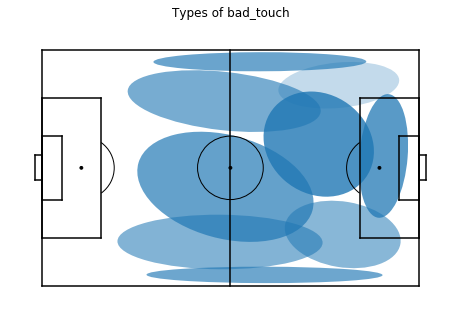

In [184]:
for m_i in models_i:
    ax = mps.field(show=False,figsize=8)
    print(m_i.name,m_i.n_components)
    strengths_i = m_i.weights_ / np.max(m_i.weights_) * 0.8
    for i,(mean,covar,strength_i) in enumerate(zip(m_i.means_, m_i.covariances_,strengths_i)):
        vis.add_ellips(ax,mean[:2],covar[:2,:2],alpha=strength_i)
        x,y = mean[:2]
        we = w_i[f"{m_i.name}_{i}"].values
        dx = np.average(m_i.df["dx"].values,weights=we)
        dy = np.average(m_i.df["dy"].values,weights=we)
        d = 1
        strength_ii=1
        vis.add_arrow(ax,x,y,d*dx,d*dy,
                                  alpha=strength_ii,
                                  linewidth=2*strength_ii,
                                  arrowsize=2.5*strength_ii,
                                  #linewidth=2,
                                  threshold=1)
    plt.title(f"Types of {m_i.name}")
    plt.show()

dribble_0 27055 2462.136837369579


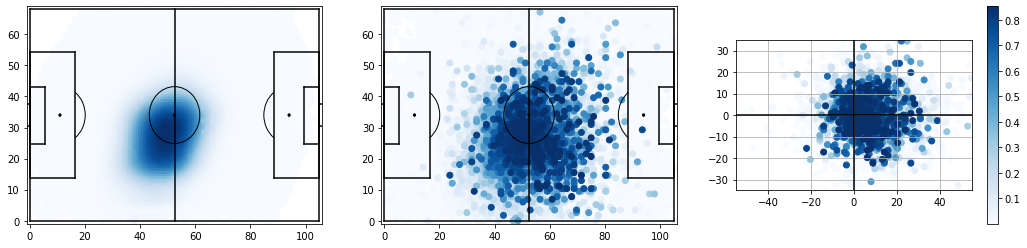

dribble_1 23311 1764.4405081302518


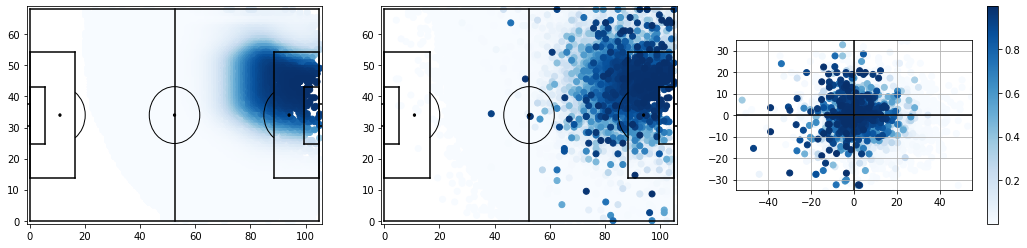

dribble_2 10456 530.2412237719606


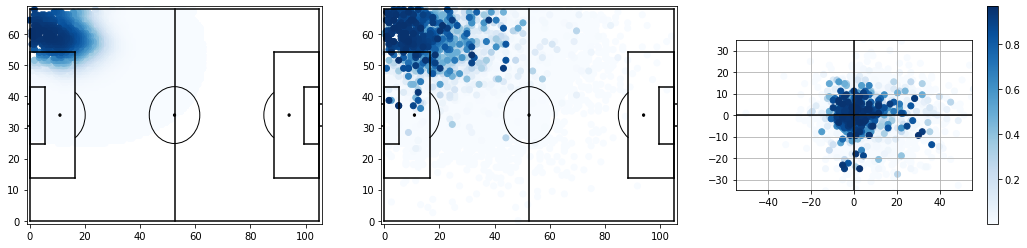

dribble_3 12128 1278.1793438562677


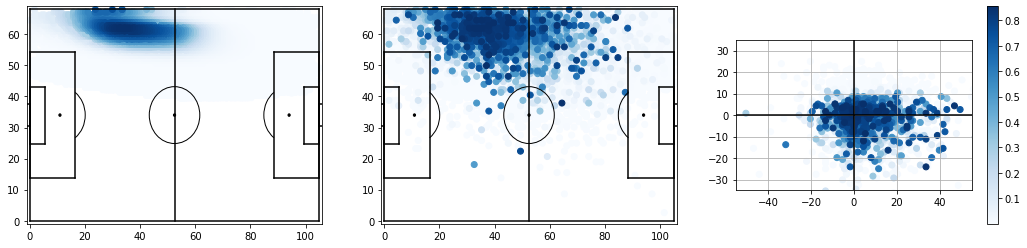

dribble_4 14610 1208.070649481066


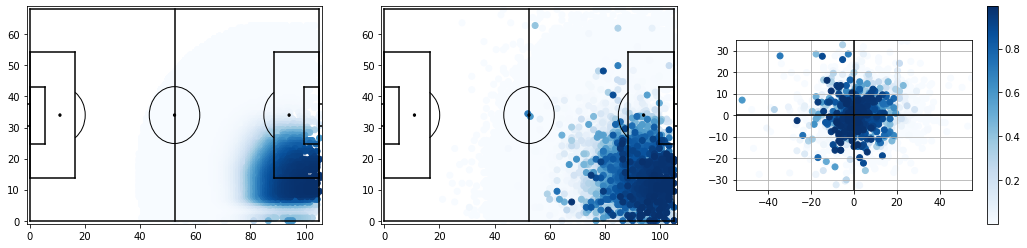

In [86]:
for column in w_i.columns[:5]:
    probs = w_i[column]
    pos_prob_idx = probs > 1e-10
    print(column,sum(pos_prob_idx),sum(probs))
    dfc = a.reset_index()[pos_prob_idx].copy()
    dfc["membership"] = probs[pos_prob_idx]
    dfc = dfc.sort_values("membership",ascending=True)

    axs = vis.axes3()
    sc = axs[0].scatter(dfc.x,dfc.y,c=dfc.membership,cmap="Blues")
    plt.colorbar(sc)
    axs[1].scatter(dfc.x + dfc.dx,dfc.y + dfc.dy,c=dfc.membership,cmap="Blues")
    axs[2].scatter(dfc.dx,dfc.dy,c=dfc.membership,cmap="Blues")
    plt.show()

100%|██████████| 95/95 [00:01<00:00, 57.99it/s]


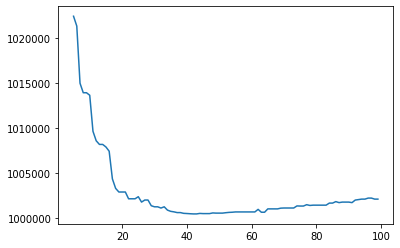

In [89]:
def bic(models):
    n_data = sum(m.weights.sum() for m in models)
    n_parameters = sum(m._n_parameters() for m in models)
    L = sum(m.likelihood for m in models)
    tu = np.log(n_data) * n_parameters, np.log(n_data) * n_parameters - 2 * L
    return tu[1]

x = []
y = []
for i in tqdm.tqdm(list(range(5,100))):
    models_ll = pat.ilp_select_models_likelihood(can_i,i,verbose=False)
    x.append(i)
    y.append(bic(models_ll))

plt.plot(x,y)
plt.show()

1.5707963267948966

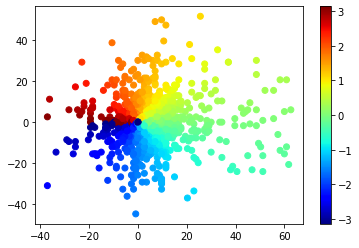

In [223]:
#plt.hist(np.nan_to_num((a.dy / a.dx),nan=2),bins=100)
#plt.show()
# plt.hist(a.mov_angle_a0,bins=200)
# plt.show()
b = a[:2000]
plt.scatter(b.dx,b.dy,c=b.mov_angle_a0,cmap="jet")
plt.colorbar()
plt.show()

In [185]:
cols_ii = [#"x","y",
        #"dx","dy"
        #"dist_to_goal_a0",
        #"angle_to_goal_a0",
        #"mov_d_a0",
        "mov_angle_a0"
        #"dx_a0",
        #"dy_a0"
       ]
w_i = probabilities(models_i)
can_ii = candidates(a,cols_ii,w_i,n=5)

tackle_7:   0%|          | 0/5 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.


out_3:  40%|████      | 2/5 [00:00<00:00, 15.39it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.


out_4:  40%|████      | 2/5 [00:00<00:00, 18.36it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
out_5:  40%|████      | 2/5 [00:00<00:00, 18.29it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
out_

out_11:  40%|████      | 2/5 [00:00<00:00, 17.92it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
out_12:  40%|████      | 2/5 [00:00<00:00, 19.06it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
ou

out_20:  40%|████      | 2/5 [00:00<00:00, 19.11it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
out_21:  40%|████      | 2/5 [00:00<00:00, 19.44it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
ou

out_26:  40%|████      | 2/5 [00:00<00:00, 17.02it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
out_27:  40%|████      | 2/5 [00:00<00:00, 18.63it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
fo

receival_2: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


receival_9:  80%|████████  | 4/5 [00:03<00:00,  1.01it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.


receival_16:  80%|████████  | 4/5 [00:03<00:00,  1.30it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.


receival_23:  80%|████████  | 4/5 [00:01<00:00,  2.07it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.


dribble_17: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


owngoal_0:  40%|████      | 2/5 [00:00<00:00, 18.96it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
yellow_card_1:  40%|████      | 2/5 [00:00<00:00, 18.21it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate point

keeper_catch_8:   0%|          | 0/5 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
keeper_catch_8:  60%|██████    | 3/5 [00:00<00:00, 16.03it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points 

red_card_0:  60%|██████    | 3/5 [00:00<00:00, 15.07it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
shot_0:   0%|          | 0/5 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
shot_2:   0%|          | 0/5 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initial

take_on_12:   0%|          | 0/5 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.


cross_0:   0%|          | 0/5 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
cross_0:  60%|██████    | 3/5 [00:00<00:00,  7.02it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
cross_11:  60%|██████    | 3/5 [00:00<00:00, 22.80it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
intercep

interception_7:  60%|██████    | 3/5 [00:01<00:00,  2.51it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.


interception_10:  40%|████      | 2/5 [00:00<00:00, 18.70it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
interception_13:  40%|████      | 2/5 [00:00<00:00, 17.02it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplica

interception_21:  60%|██████    | 3/5 [00:00<00:00,  3.57it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.


shot_penalty_3: 100%|██████████| 2/2 [00:00<00:00, 65.07it/s]
shot_penalty_4: 0it [00:00, ?it/s]
offside_2:  40%|████      | 2/5 [00:00<00:00, 17.69it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.


bad_touch_3:  40%|████      | 2/5 [00:00<00:00, 15.32it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/ipykernel_launcher.py:51: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.


bad_touch_8: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


In [187]:
models_ii = pat.ilp_select_models_bic(can_ii,verbose=True)
print(len(models_ii))
list((m.name,m.n_components) for m in models_ii)

Iter	Lower Bound	Upper Bound	Gap

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -3.522e+06  -3.668e+07  +3e+07  7e-03  2e-09  1e+00  1e+04    ---    ---    1  1  - |  -  - 
 1  -3.911e+06  -1.551e+07  +1e+07  2e-03  1e-09  1e+03  5e+03  0.7208  1e-01   0  1  1 |  0  0
 2  -3.959e+06  -5.396e+06  +1e+06  2e-04  1e-10  2e+02  6e+02  0.8963  2e-02   0  1  1 |  0  0
 3  -3.978e+06  -4.219e+06  +3e+05  8e-05  2e-11  7e+01  1e+02  0.9412  1e-01   0  2  2 |  0  0
 4  -3.992e+06  -4.041e+06  +5e+04  3e-05  5e-12  2e+01  2e+01  0.9443  2e-01   0  2  2 |  0  0
 5  -4.004e+06  -4.015e+06  +1e+04  6e-06  1e-12  4e+00  4e+00  0.9083  2e-01   0  1  1 |  0  0
 6  -4.008e+06  -4.010e+06  +2e+03  1e-06  2e-13  7e-01  7e-01  0.9573  1e-01   0  1  1 |  0  0
 7  -4.009e+06  -4.009e+06  +3e+02  2e-07  6e-14  1e-01  1e-01  0.9373  8e-02   0  1  1 |  0  0
 8  -4.009e+0

[('tackle_0', 1),
 ('tackle_1', 1),
 ('tackle_2', 1),
 ('tackle_3', 1),
 ('tackle_4', 1),
 ('tackle_5', 1),
 ('tackle_6', 1),
 ('tackle_7', 1),
 ('tackle_8', 1),
 ('tackle_9', 1),
 ('tackle_10', 1),
 ('out_0', 1),
 ('out_1', 1),
 ('out_2', 1),
 ('out_3', 1),
 ('out_4', 1),
 ('out_5', 1),
 ('out_6', 1),
 ('out_7', 1),
 ('out_8', 1),
 ('out_9', 1),
 ('out_10', 1),
 ('out_11', 1),
 ('out_12', 1),
 ('out_13', 1),
 ('out_14', 1),
 ('out_15', 1),
 ('out_16', 1),
 ('out_17', 1),
 ('out_18', 1),
 ('out_19', 1),
 ('out_20', 1),
 ('out_21', 1),
 ('out_22', 1),
 ('out_23', 1),
 ('out_24', 1),
 ('out_25', 1),
 ('out_26', 1),
 ('out_27', 1),
 ('foul_0', 1),
 ('foul_1', 1),
 ('foul_2', 1),
 ('foul_3', 1),
 ('foul_4', 1),
 ('foul_5', 1),
 ('foul_6', 1),
 ('foul_7', 1),
 ('foul_8', 1),
 ('receival_0', 1),
 ('receival_1', 1),
 ('receival_2', 1),
 ('receival_3', 1),
 ('receival_4', 1),
 ('receival_5', 1),
 ('receival_6', 1),
 ('receival_7', 1),
 ('receival_8', 1),
 ('receival_9', 1),
 ('receival_10', 1)

In [134]:
np.arctan2(0.001,0.000001)

1.5697963271282298

100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


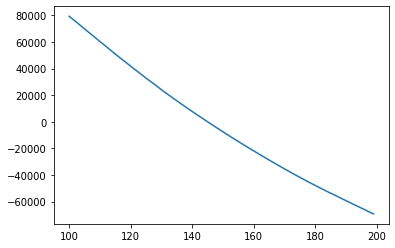

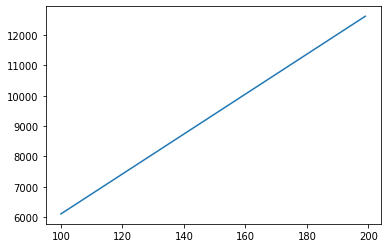

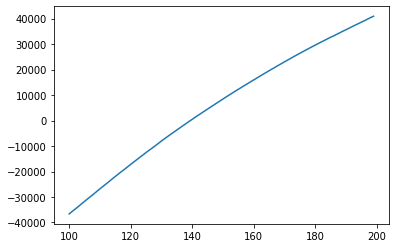

In [153]:
def bic(models):
    n_data = sum(m.weights.sum() for m in models)
    n_parameters = sum(m._n_parameters() for m in models)
    L = sum(m.likelihood for m in models)
    return np.log(n_data) * n_parameters , L, np.log(n_data) * n_parameters - 2 * L

x = []
y = []
e = []
ls = []
for i in tqdm.tqdm(list(range(100,200))):
    models_ll = pat.ilp_select_models_likelihood(can_ii,i,verbose=False)
    x.append(i)
    err,l, b = bic(models_ll)
    y.append(b)
    ls.append(l)
    e.append(err)
plt.plot(x,y)
plt.show()
plt.plot(x,e)
plt.show()
plt.plot(x,ls)
plt.show()

In [160]:
#help(pd.Series)
pd.core.generic.NDFrame

pandas.core.generic.NDFrame

In [188]:
w_ii = probabilities(models_ii)
#w_ii

tackle


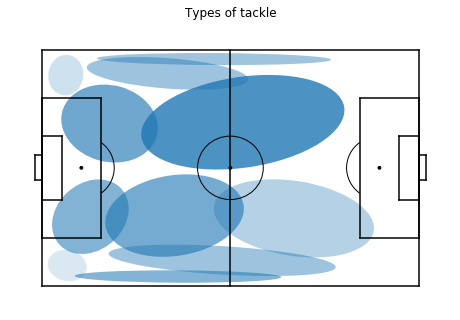

out


../pattern/vis.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


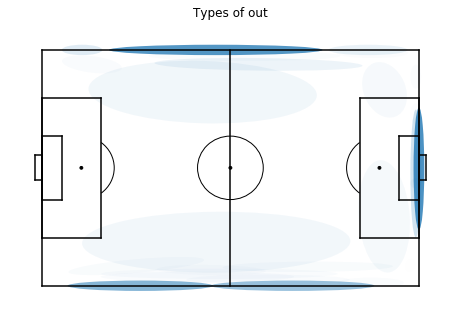

foul


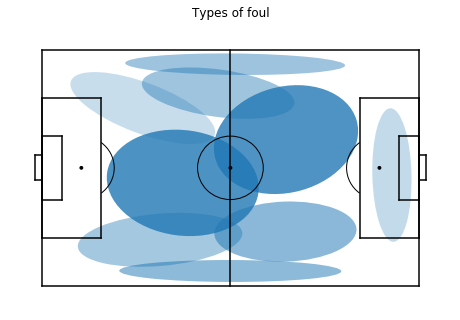

receival


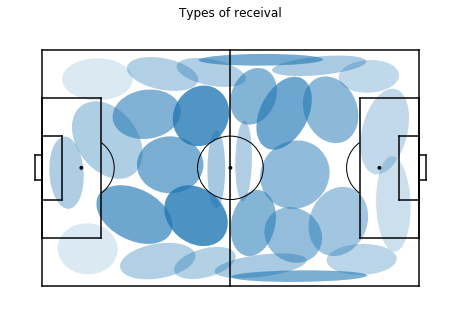

dribble


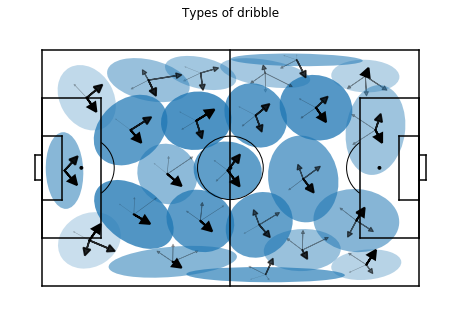

owngoal


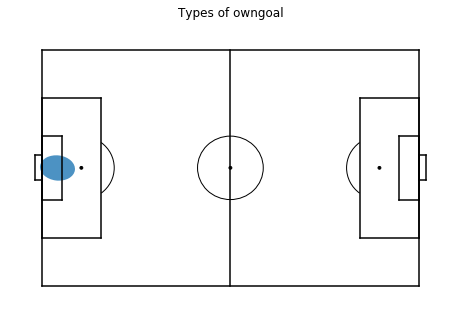

yellow_card


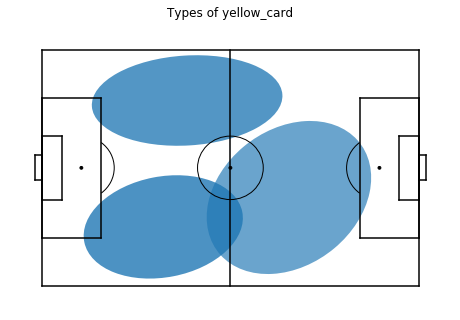

keeper_catch


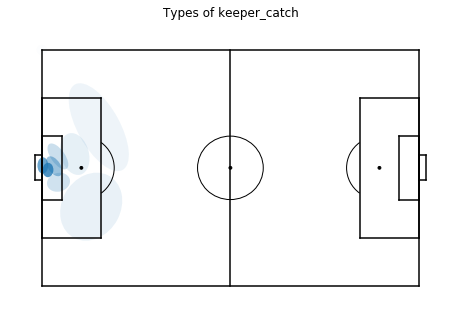

corner


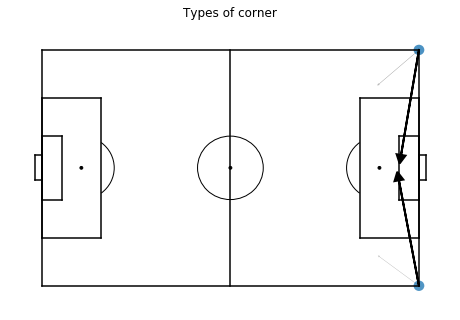

freekick


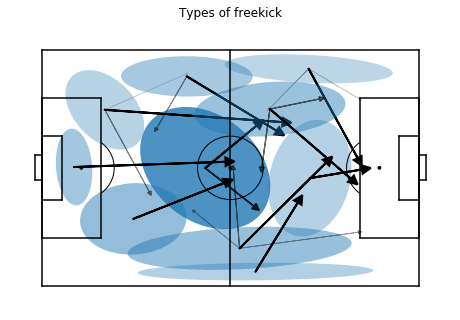

red_card


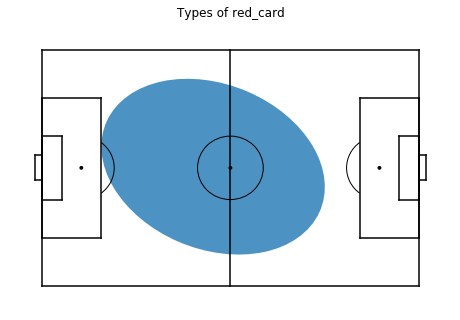

shot


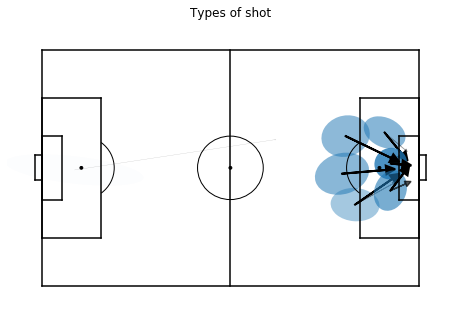

throw_in


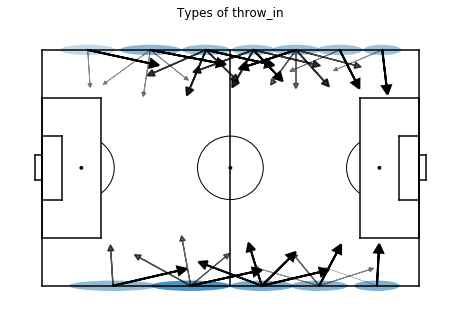

take_on


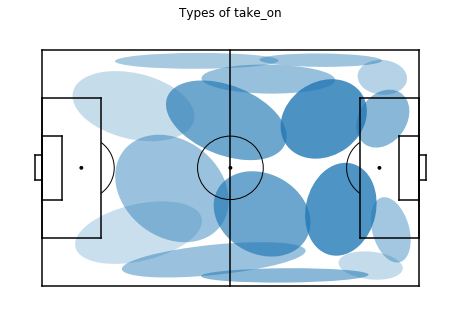

cross


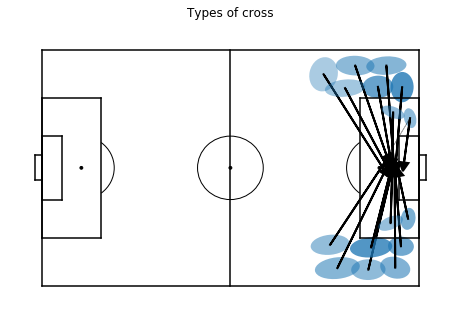

pass


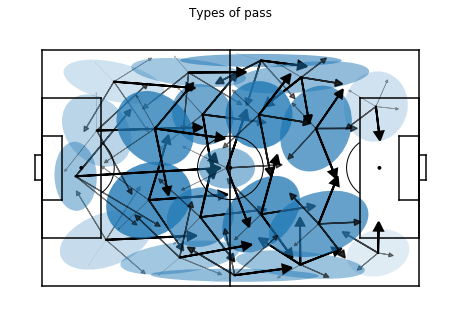

goalkick


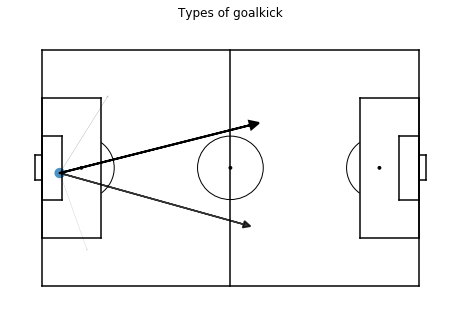

interception


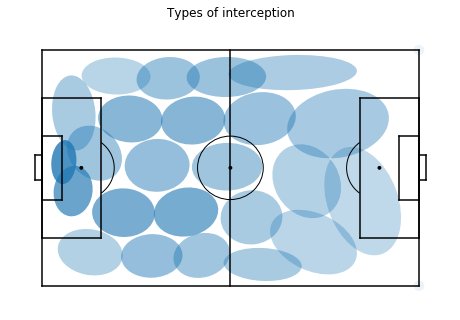

shot_penalty


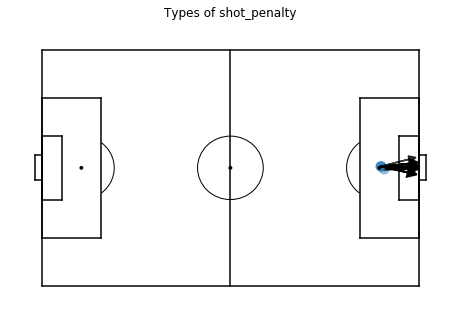

offside


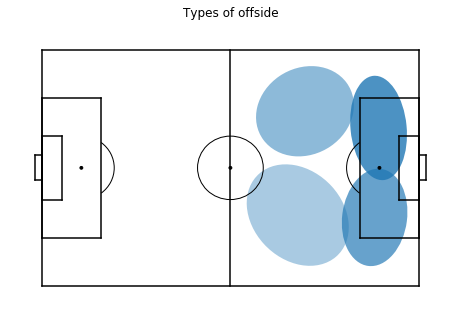

clearance


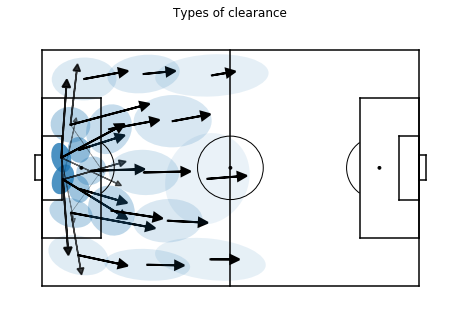

goal


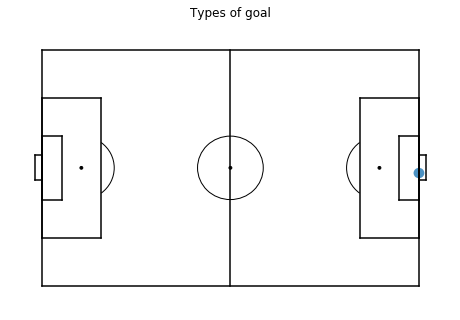

bad_touch


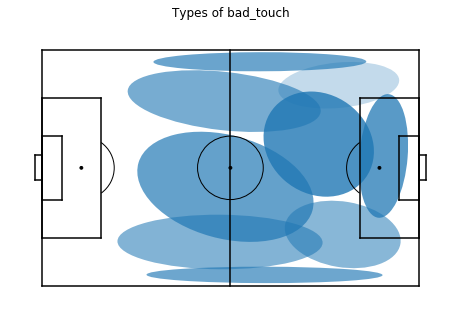

In [189]:
for m_i in models_i:
    ax = mps.field(show=False,figsize=8)
    print(m_i.name)
    strengths_i = m_i.weights_ / np.max(m_i.weights_) * 0.8
    for i,(mean,covar,strength_i) in enumerate(zip(m_i.means_, m_i.covariances_,strengths_i)):
        vis.add_ellips(ax,mean,covar,alpha=strength_i)
        x,y = mean
        for m_ii in models_ii:
            if f"{m_i.name}_{i}" == m_ii.name:
                strengths_ii = m_ii.weights_ / np.max(m_ii.weights_)
                for j in range(m_ii.n_components):
                    we = w_ii[f"{m_ii.name}_{j}"].values
                    #x = np.average(m_ii.df["x"].values,weights=we)
                    #y = np.average(m_ii.df["y"].values,weights=we)
                    dx = np.average(m_ii.df["dx"].values,weights=we)
                    dy = np.average(m_ii.df["dy"].values,weights=we)
                    strength_ii = strengths_ii[j]
                    d=1
                    vis.add_arrow(ax,x,y,d*dx,d*dy,
                                  alpha=strength_ii,
                                  linewidth=2*strength_ii,
                                  arrowsize=2.5*strength_ii,
                                  #linewidth=2,
                                  threshold=1)
    plt.title(f"Types of {m_i.name}")
    plt.show()

dribble_0 9


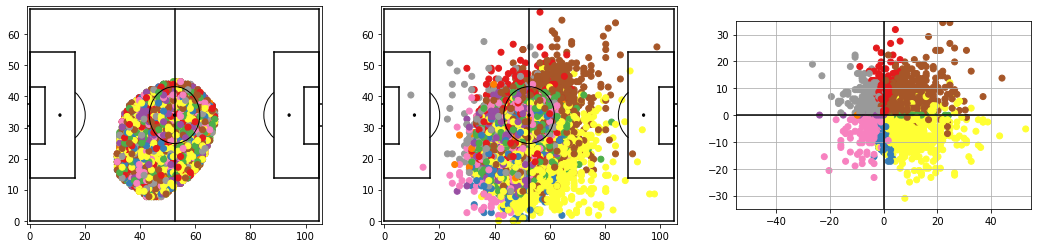

dribble_1 5


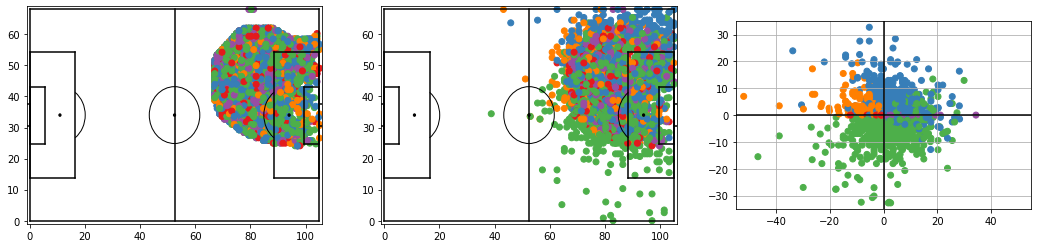

dribble_2 9


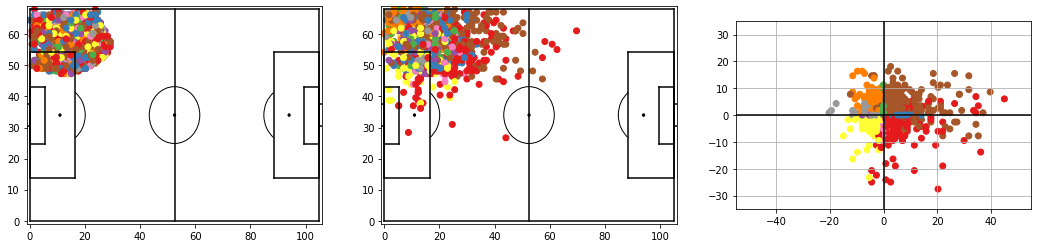

dribble_3 10


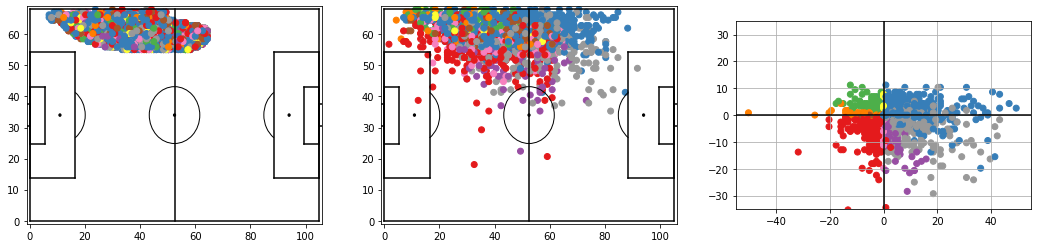

dribble_4 10


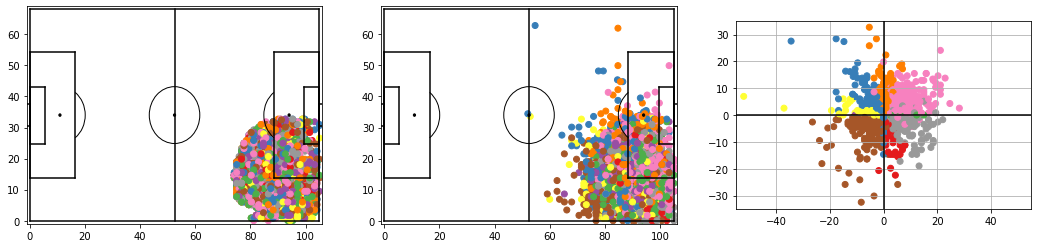

dribble_5 7


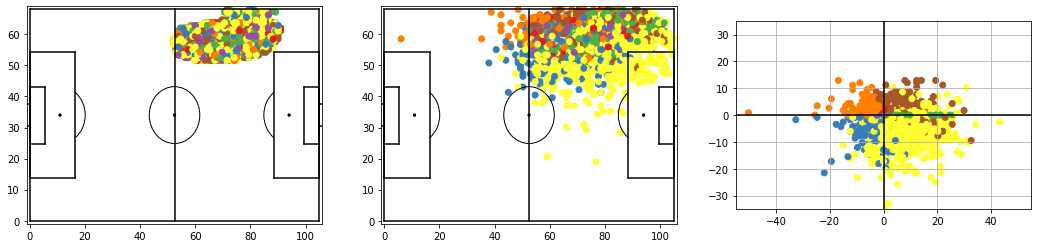

dribble_6 9


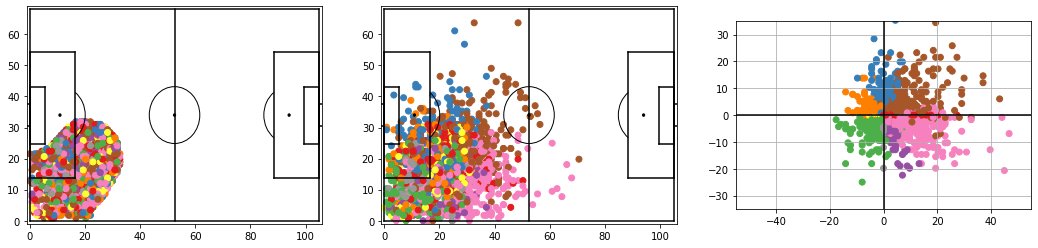

dribble_7 10


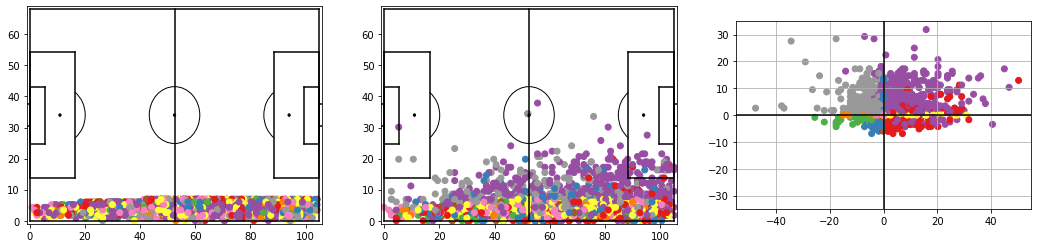

dribble_8 10


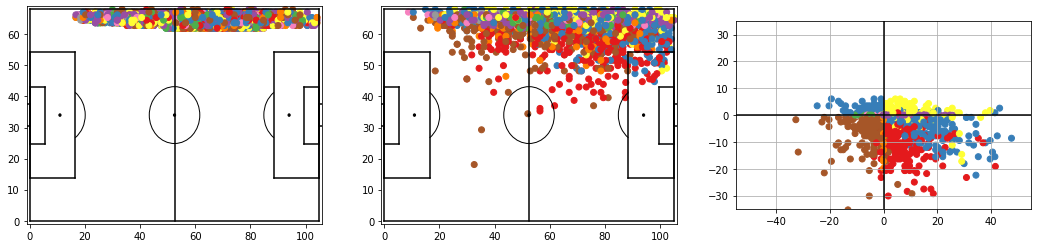

dribble_9 9


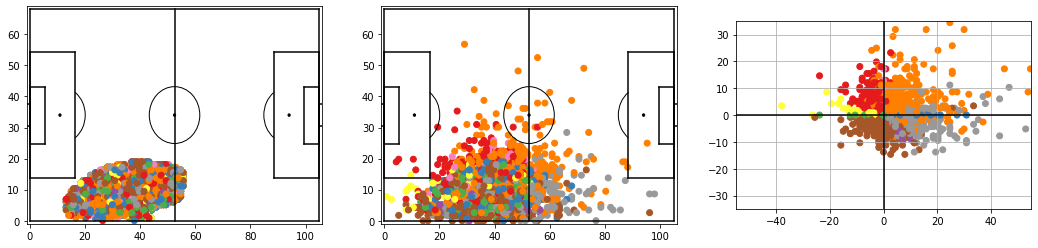

In [98]:
import numpy as np
for prefix in w_i.columns[:10]:
    prefix_columns = list(c for c in w_ii.columns if prefix + "_" in c)
    print(prefix,len(prefix_columns))
    vis.plot_actions(a,w_ii[prefix_columns],samplefn="uni")

pass_9_3 25214


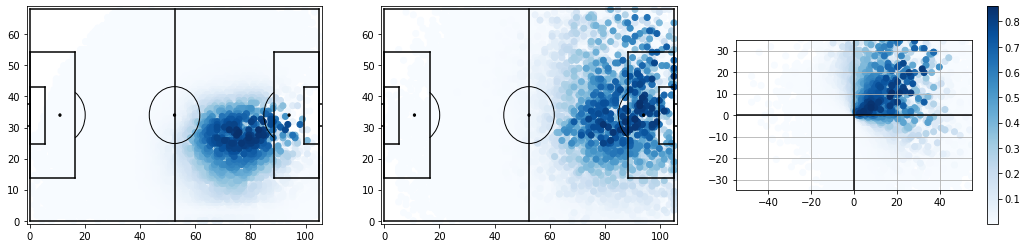

pass_10_0 12913


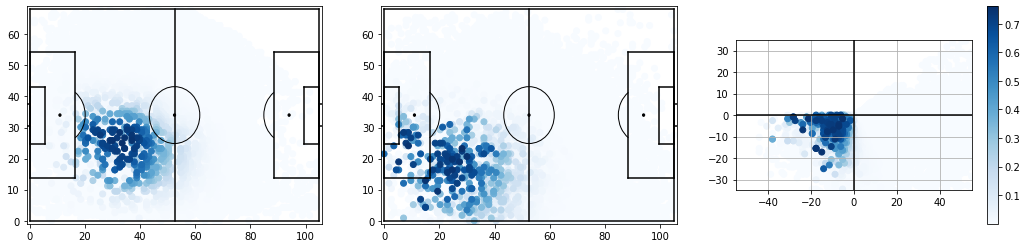

pass_10_1 19173


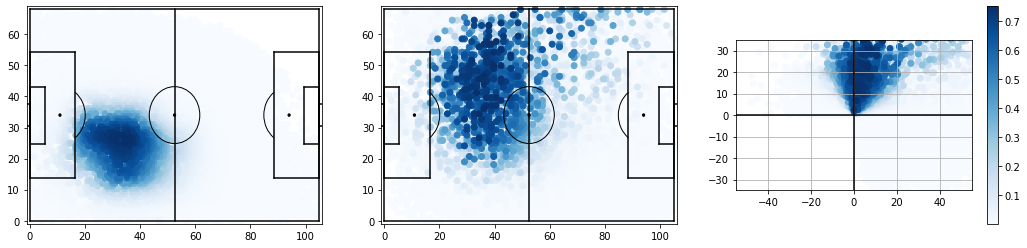

pass_10_2 11532


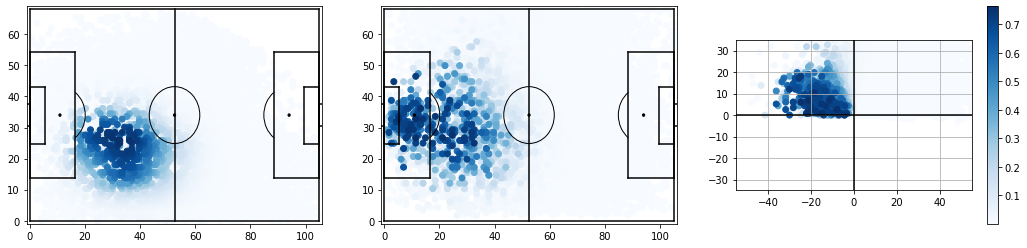

pass_10_3 21596


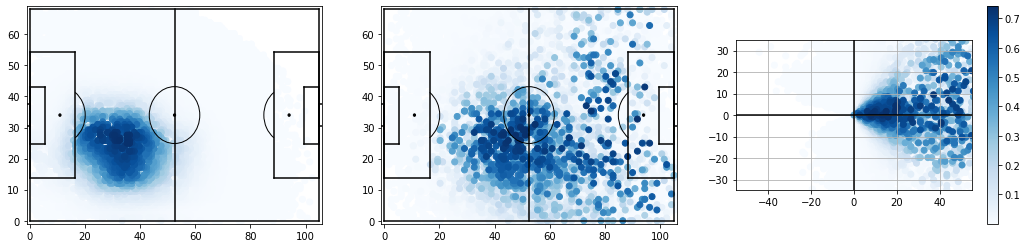

pass_10_4 19060


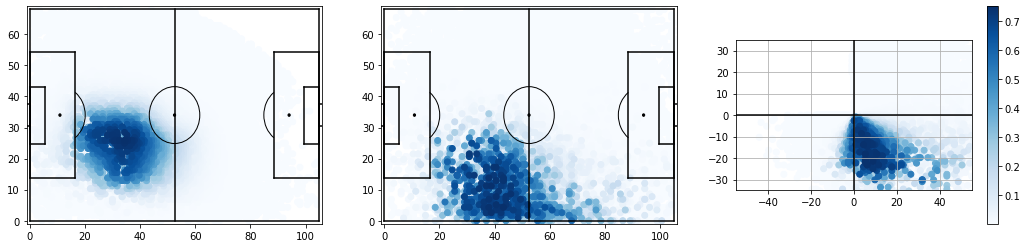

pass_11_0 16514


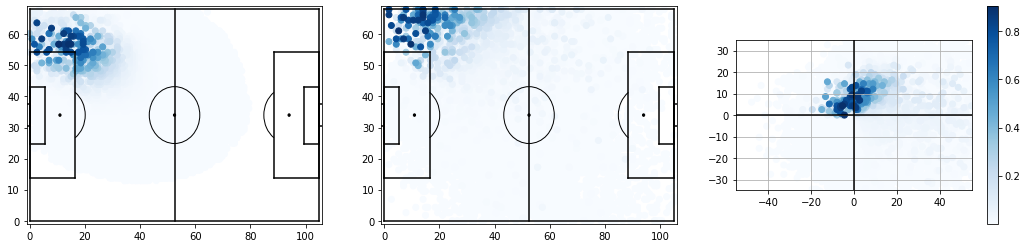

pass_11_1 13562


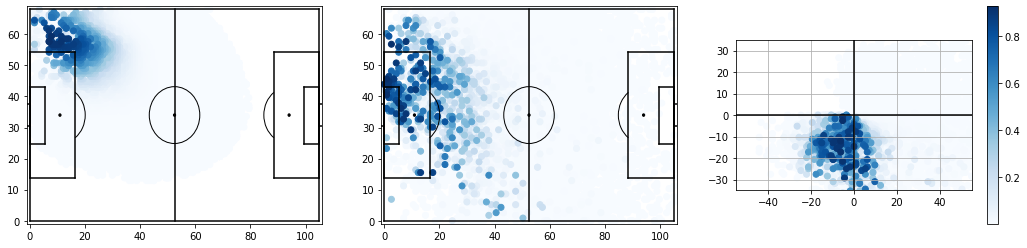

pass_11_2 15261


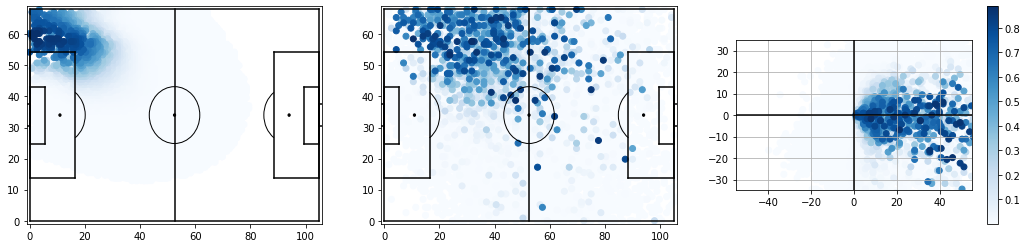

pass_12_0 12670


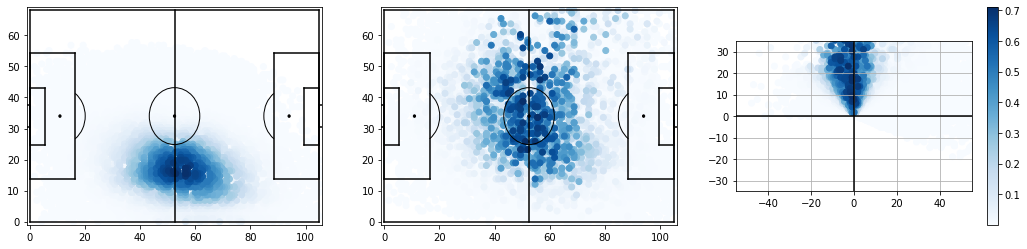

In [237]:
for column in w_ii.columns[200:210]:
    probs = w_ii[column]
    pos_prob_idx = probs > 1e-10
    print(column,sum(pos_prob_idx))
    dfc = a.reset_index()[pos_prob_idx].copy()
    dfc["membership"] = probs[pos_prob_idx]
    dfc = dfc.sort_values("membership",ascending=True)

    axs = vis.axes3()
    sc = axs[0].scatter(dfc.x,dfc.y,c=dfc.membership,cmap="Blues")
    plt.colorbar(sc)
    axs[1].scatter(dfc.x + dfc.dx,dfc.y + dfc.dy,c=dfc.membership,cmap="Blues")
    axs[2].scatter(dfc.dx,dfc.dy,c=dfc.membership,cmap="Blues")
    plt.show()

In [ ]:
ucprobas = pat.uncouple_probabilities(probas,a.is_home.values)
ucprobas
ucprobas.values.sum()

In [ ]:
prev = ucprobas.values[:-1]
nex = ucprobas.values[1:]
print(prev.shape)
trans = np.dot(prev.T,nex)
plt.matshow(trans)
plt.colorbar()
plt.show()
trans /= trans.sum()
# for i in range(len(trans[0])):
#     trans[i,:] /= trans[i,:].sum()
trans.sum()
ori_trans = trans

In [ ]:
forwardtrans = trans.copy()
for i in range(len(forwardtrans[0])):
     forwardtrans[i,:] /= forwardtrans[i,:].sum()
forwardtrans.sum()

backwardtrans = trans.T.copy()
for i in range(len(backwardtrans[0])):
     backwardtrans[i,:] /= backwardtrans[i,:].sum()
backwardtrans.sum()

In [ ]:
def get_name(i):
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    return "_".join([ty,str(k),str(is_opp)])

In [ ]:
from sklearn.cluster import SpectralClustering

nc = 10

clustering = SpectralClustering(affinity="precomputed",n_clusters=nc).fit((sim + sim.T)/2)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clustering.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

In [ ]:
sim = (np.dot(forwardtrans,backwardtrans) + np.dot(backwardtrans,forwardtrans))/2

from sklearn.cluster import KMeans

nc = 30

clus = KMeans(nc).fit(sim)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clus.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

In [ ]:
from collections import Counter

sim = (np.dot(forwardtrans,backwardtrans) + np.dot(backwardtrans,forwardtrans))/2

plt.matshow(sim)
plt.colorbar()
plt.show()

from sklearn.cluster import AgglomerativeClustering
nc = 50
clustering = AgglomerativeClustering(affinity="euclidean",linkage="average",n_clusters=nc).fit(sim.T)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clustering.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

In [ ]:
i = 170
ty,k = gmme._global_to_local(i % gmme.total_components())
is_opp = i > gmme.total_components() - 1
print(ty,k,is_opp)
vis.plot_component_w_arrow(gmme.models[ty],k,color="red",mirror=is_opp)

oldty,oldk,oldopp = ty,k,is_opp

v = np.zeros(gmme.total_components()*2)
v[i] = 1

forv = np.dot(np.dot(v,forwardtrans),backwardtrans)
plt.plot(forv)
plt.show()

backv = np.dot(np.dot(v,backwardtrans),forwardtrans)
plt.plot(backv)
plt.show()

newv = (forv + backv)/2
plt.plot(newv)
plt.show()

for j in np.argsort(newv)[::-1][:4]:
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    print(ty,k,is_opp)
    ax = vis.plot_component_w_arrow(gmme.models[oldty],oldk,color="red",mirror=oldopp,show=False)
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp)

In [ ]:
trans1 = ori_trans.copy()
for _i in range(10):
    print(trans1.sum())
    trans1 = np.dot(ori_trans.T,trans1)
    trans1 /= trans1.sum()

In [ ]:
delta_trans = trans1 - ori_trans
plt.matshow(delta_trans)
plt.colorbar()
plt.show
delta_trans.max(), delta_trans.min()

In [ ]:
trans = delta_trans
trans = trans1

In [ ]:
trans.sum()

In [ ]:
plt.hist([p for p,i,j in probs])
plt.show()

In [ ]:
probs = []
for i in range(len(trans)):
    for j in range(len(trans)):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs]# if i != j]

cols = list(ucprobas.columns)

def test(i,j):
    return True
    return "goal1" in cols[j]# and "opp" not in cols[j]
    return "shot" in cols[i] and "opp" not in cols[j]

interestmovs = [(p,i,j) for p,i,j in movs 
                if test(i,j)
                #"pass" not in cols[i]
                   # and "receival" not in cols[i]
                   # and "dribble" not in cols[i]
               ]

for p,i,j in interestmovs[:10]:
    print(p,i,j)
    print(cols[i],"(red)","->",cols[j],"(blue)")
    ax = mps.field(show=False)
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="red",mirror=is_opp,show=False)
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp,show=False)
    plt.show()

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 50:
        break

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 5:
        break